<a href="https://colab.research.google.com/github/Roozbeh96/CSCI-5525-Advanced-ML/blob/Temp/Finalproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [4]:
train.drop(['id'], axis = 1, inplace = True)

In [5]:
train.head()

,text,author
0,"This process, however, afforded me no means of...",EAP
1,It never once occurred to me that the fumbling...,HPL
2,"In his left hand was a gold snuff box, from wh...",EAP
3,How lovely is spring As we looked from Windsor...,MWS
4,"Finding nothing else, not even gold, the Super...",HPL


In [ ]:
train['text'].apply(lambda x:len(str(x).split())).max()

861

In [ ]:
train.describe()

,text,author
count,19579,19579
unique,19579,3
top,"This process, however, afforded me no means of...",EAP
freq,1,7900


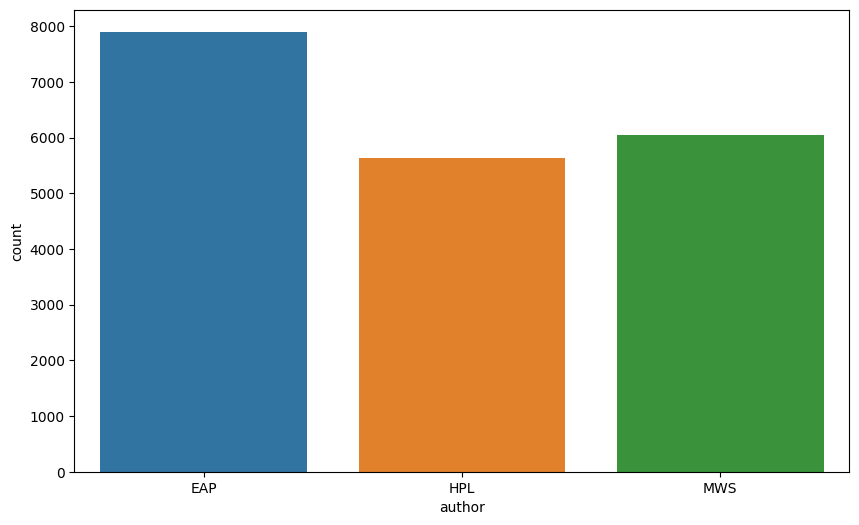

In [ ]:
plt.figure(figsize=(10,6))
sns.countplot(x='author',hue='author', data = train)
plt.show()

In [ ]:
from plotly import graph_objs as go
temp = train.groupby('author').count()['text'].reset_index().sort_values(by='text',ascending=False)
temp.style.background_gradient(cmap='Purples')

,author,text
0,EAP,7900
2,MWS,6044
1,HPL,5635


In [ ]:
fig = go.Figure(go.Funnelarea(
    text =temp.author,
    values = temp.text,
    title = {"position": "top center", "text": "Funnel-Chart of Authors Distribution"}
    ))
fig.show()

In [ ]:
from wordcloud import WordCloud, STOPWORDS

In [ ]:
# Join all text together and space them with '' which is space to count for word cloud
text_data = ''.join(train['text'].dropna())


wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis',
    stopwords=STOPWORDS,
    max_words=200
).generate(text_data)



In [ ]:
text_data_LOP = 'LOP'.join(train['text'].dropna())
print(text_data_LOP[0:250])

This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.LOPIt never once oc


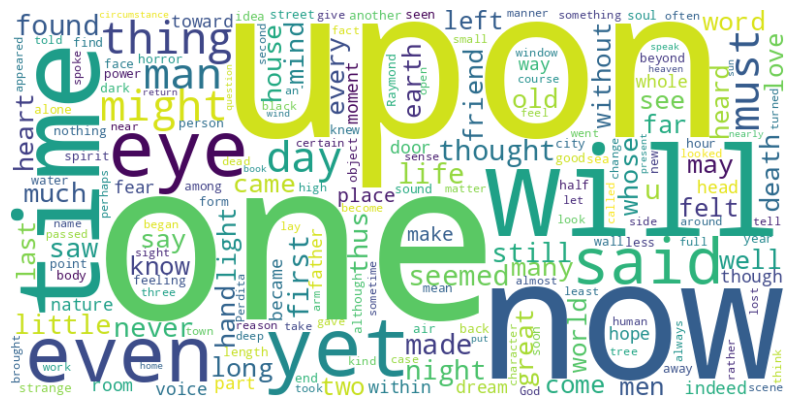

In [ ]:
# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide the axes
plt.show()

In [6]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU,SimpleRNN
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import to_categorical
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from tensorflow.keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping

In [47]:
from sklearn.preprocessing import LabelEncoder

In [109]:
X_train, X_val, Y_train, Y_val = train_test_split(train.text.values,
                                                    train.author.values,
                                                    stratify = train.author.values,
                                                    test_size = 0.2,
                                                    random_state = 37)
Y_train = pd.Series(Y_train)
Y_val = pd.Series(Y_val)

le = LabelEncoder()

# For different authors, the label would be 0,1,2
Y_train = le.fit_transform(Y_train)
Y_val = le.fit_transform(Y_val)
# Change the label for each author to one hot vector[0]->[1,0,0],[1]->[0,1,0],[2]->[0,0,1]
Y_train = to_categorical(Y_train, num_classes=3)
Y_val = to_categorical(Y_val, num_classes=3)

In [112]:
# Make a dictionary based on the input dataset. Give label to each unique word.
# "The"->12, "Good"->53, "Car"->254, "is"->30, ...
token = text.Tokenizer(num_words=None)
max_len = 1500

token.fit_on_texts(list(X_train) + list(X_val))

# Change the input dataset to the sequence of numbers
# "The car is good"->[12,254,30,53]
X_train_seq = token.texts_to_sequences(X_train)
X_val_seq = token.texts_to_sequences(X_val)

#zero pad the sequences
# maxlen = 10->[12,254,30,53,0,0,0,0,0,0]
X_train_pad = sequence.pad_sequences(X_train_seq, maxlen=max_len)
X_val_pad = sequence.pad_sequences(X_val_seq, maxlen=max_len)

word_index = token.word_index

In [115]:
# Number of unique words in the whole dataset
len(word_index)

25943

In [131]:
num_classes = 3  # For the 3 authors in the dataset

with strategy.scope():
    # Create the SimpleRNN model
    model = Sequential()
    # Via embedding, each word would be in word_index would be vector in space with 300 variables.
    # "Good"->53->[0.2, -0.1, -0.65, ...., 0.001] with length of 300.
    # These numbers are learnable. Each input can have the size of max_len by 300 in which is number of
    # words in a statement (can be padded with zeros) with 300 features.
    model.add(Embedding(input_dim=len(word_index) + 1,
                        output_dim=300,
                        input_length=max_len))
    # the input to the SimpleRNN layer is a 3D tensor of shape:(batch_size, max_len = 1500, 300)
    # At each time step, the size of the x_t is (batch_size,300) which is all the t^{th} words in the batch.
    # The SimpleRNN computes the hidden state h_t based on x_t and the previous hidden state h_{t-1}
    # h_t=tanh(x_t*W_x+h_{t-1}*W_h+b)->h_t: (batch_size, 100) Activation function is tanh(applied element-wise).
    # x_t: (batch_size,300)
    # W_x: (300,100)
    # W_h: (100,100)
    # b: (100,1)
    # For calculating the loss function, only h_t is used which is afftected by all the h_{t-1}s
    model.add(SimpleRNN(100))
    model.add(Dense(num_classes, activation='softmax'))  # 3 neurons for 3 classes

    # Compile the model with categorical cross-entropy
    model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

model.load_weights('spooky_author_simpleRNN.weights.h5')
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_8 (SimpleRNN)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [132]:
model.fit(X_train_pad, Y_train, epochs=5, batch_size=64*strategy.num_replicas_in_sync)

Epoch 1/5
245/245 ━━━━━━━━━━━━━━━━━━━━ 587s 2s/step - accuracy: 0.5072 - loss: 0.9713
Epoch 2/5
245/245 ━━━━━━━━━━━━━━━━━━━━ 595s 2s/step - accuracy: 0.9094 - loss: 0.2620
Epoch 3/5
245/245 ━━━━━━━━━━━━━━━━━━━━ 607s 2s/step - accuracy: 0.9885 - loss: 0.0462
Epoch 4/5
245/245 ━━━━━━━━━━━━━━━━━━━━ 623s 2s/step - accuracy: 0.9977 - loss: 0.0124
Epoch 5/5
245/245 ━━━━━━━━━━━━━━━━━━━━ 578s 2s/step - accuracy: 0.8690 - loss: 0.3378


In [121]:
model.save_weights('spooky_author_simpleRNN.weights.h5')

In [129]:
from sklearn.metrics import roc_auc_score

def roc_auc(predictions, target):
    '''
    This function returns the AUC Score for multi-class predictions and labels.
    '''
    # Ensure the target is one-hot encoded
    if len(target.shape) == 1:
        target = to_categorical(target, num_classes=predictions.shape[1])

    # Compute the ROC AUC score for multi-class
    return roc_auc_score(target, predictions, multi_class='ovr')

In [130]:
scores = model.predict(X_val_pad)
print("Auc: %.2f%%" % (roc_auc(scores,Y_val)))

123/123 ━━━━━━━━━━━━━━━━━━━━ 36s 282ms/step
Auc: 0.46%
